<a id="top"></a>
# OpenCV Spatial AI competition - Model Optimizer

## Purpose of this development:
Optimize the Tensorflow model to detect weed species for the BenchBot project.

## Prerequisites


This solution requires the following:
- All files are present and in the following directory structure:
    - **Optimizer_Benchmark.ipynb** - This Jupyter* Notebook
    - **DataSets in Data Availability Section (WiKi)** - 
    
It is recommended that you have already read the following from [Get Started on the Intel® DevCloud for the Edge](https://devcloud.intel.com/edge/home/):
- [Overview of the Intel® DevCloud for the Edge](https://devcloud.intel.com/edge/get_started/devcloud/)
- [Overview of the Intel® Distribution of OpenVINO™ toolkit](https://devcloud.intel.com/edge/get_started/openvino/)

<br><div class=note><i><b>Note: </b>It is assumed that the server this sample is being run on is on the Intel® DevCloud for the Edge which has Jupyter* Notebook customizations and all the required libraries already installed.  If you download or copy to a new server, this sample may not run.</i></div>


### Imports
We begin by importing all the Python* modules that will be used within this Jupyter* Notebook to run and display the results of the semantic segmentation application on the Intel® DevCloud for the Edge:
- [os](https://docs.python.org/3/library/os.html#module-os) - Operating system specific module (used for file name parsing)
- [time](https://docs.python.org/3/library/time.html#module-time) - Time tracking module (used for measuring execution time)
- [matplotlib.pyplot](https://matplotlib.org/) - pyplot is used for displaying output images
- [sys](https://docs.python.org/3/library/sys.html#module-sys) - System specific parameters and functions
- [qarpo.demoutils](https://github.com/ColfaxResearch/qarpo) - Provides utilities for displaying results and managing jobs from within this Jupyter* Notebook

Run the following cell to import the Python* dependencies needed.

<br><div class=tip><b>Tip: </b>Select a cell and then use **Ctrl+Enter** to run that cell.</div>

In [1]:
import matplotlib.pyplot as plt
import os
import time
import sys
from qarpo.demoutils import *
from qarpo.model_visualizer_link import *
print('Imported Python modules successfully.')

Imported Python modules successfully.


### Create the IR files for the inference model

The Intel® Distribution of OpenVINO™ toolkit includes the [Model Optimizer](http://docs.openvinotoolkit.org/latest/_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) used to convert and optimize trained models into the Intermediate Representation (IR) model files, and the [Inference Engine](http://docs.openvinotoolkit.org/latest/_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html) that uses the IR model files to run inference on hardware devices.  The IR model files can be created from trained models from popular frameworks (e.g. Caffe\*, Tensorflow*, etc.). 
The Intel® Distribution of OpenVINO™ toolkit also includes the [Model Downloader](http://docs.openvinotoolkit.org/latest/_tools_downloader_README.html) utility  to download some common inference models from the [Open Model Zoo](https://github.com/opencv/open_model_zoo). 

However, the architecture used by The Benchbotics is not available in the OpenVINO downloader, so the models mentioned in the introduction of this report were used.

### Converting Forzen Tensor Flow model to an OpenVINO Intermediate Representation

Next we want to run the model through the OpenVINO model optimizer to produce a Intermediate Representation (IR) that can be used to run inference using the OpenVINO inference engine. However, in order to make that possible we first have to convert the model to a format that is supported by the model optimizer. 

Tensorflow → `IR` OpenVINO


To view a graph of the model used in this application, run the cell below then select the link generated:

In [ ]:
#showModelVisualizerLink("models300x300/class_model_mobilenet_v3_small_data3_class_weights_300x300_without_softmax.pb")
showModelVisualizerLink("model_pots_512x512/4_class_model_mobilenet_v3_large_data4_combined_class_weights_512x512_without_softmax.pb")
showModelVisualizerLink("model_pots_512x512/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.pb")

These files will need to be optimized using the Model Optimizer to create the necessary IR files.  We will be running the inference model on different hardware devices which have different requirements on the precision of the model (see [Inference Engine Supported Model Formats](https://docs.openvinotoolkit.org/latest/_docs_IE_DG_supported_plugins_Supported_Devices.html#supported_model_formats) for details).  For our purposes, we will focus on the use of the two most common precisions, FP32 and FP16.

For this model, we will run the Model Optimizer using the format:
```bash
mo.py \
    --input_model <path_to_tensorflow> \
    --data_type <data_precision> \
    --output_dir <path_to_output_directory> \
    --scale <scale_value> \
    --mean_values [<channel_mean_values>] 
```

The input arguments are as follows:
- **--input_model** : The model's input *.caffemodel* file  (the *.prototxt* with the same base name will be automatically found, otherwise the `--input_proto` argument would need to be specified)
- **--data_type** : The model's data type and precision (e.g. FP16, FP32, INT8, etc.)
- **--output_dir** : Output directory where to store the generated IR model files
- **--scale** : Scaling (divide by) value to apply to input values
- **--mean_values** : Mean values (one per channel) to be subtracted from input values before scaling


The complete command will look like the following:
```bash
!mo.py \
    --input_model models/model.pb \
    --data_type <data_precision> \
    --output_dir models/FP16 \
    --input_shape [1,224,224,3]
```
We will run the command twice, first with <*data_precision*> set to `FP16` and then `FP32` to get all the IR files we will need to run inference on different devices.


In [4]:
# Create FP16 IR files
!mo.py \
--input_model model_pots_512x512/4_class_model_mobilenet_v3_large_data4_combined_class_weights_512x512_without_softmax.pb \
--data_type FP16 \
--output_dir model_pots_512x512/FP16 \
--input_shape [1,512,512,3]
#--scale 256 \
#--mean_values [127,127,127] \


# Create FP32 IR files
!mo.py \
--input_model model_pots_512x512/4_class_model_mobilenet_v3_large_data4_combined_class_weights_512x512_without_softmax.pb \
--data_type FP32 \
--output_dir model_pots_512x512/FP32 \
--input_shape [1,512,512,3]
#--scale 256 \
#--mean_values [127,127,127] \


# find all resulting IR files
!echo "\nAll IR files that were created:"
!find ./models -name "*.xml" -o -name "*.bin" 



Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u66584/OpenCV_competition/model_pots_512x512/4_class_model_mobilenet_v3_large_data4_combined_class_weights_512x512_without_softmax.pb
	- Path for generated IR: 	/home/u66584/OpenCV_competition/model_pots_512x512/FP16
	- IR output name: 	4_class_model_mobilenet_v3_large_data4_combined_class_weights_512x512_without_softmax
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,512,512,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump 

In [6]:
# Create FP16 IR files
!mo.py \
--input_model model_pots_512x512/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.pb \
--data_type FP16 \
--output_dir model_pots_512x512/FP16 \
--input_shape [1,512,512,3]
#--scale 256 \
#--mean_values [127,127,127] \


# Create FP32 IR files
!mo.py \
--input_model model_pots_512x512/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.pb \
--data_type FP32 \
--output_dir model_pots_512x512/FP32 \
--input_shape [1,512,512,3]
#--scale 256 \
#--mean_values [127,127,127] \


# find all resulting IR files
!echo "\nAll IR files that were created:"
!find ./models -name "*.xml" -o -name "*.bin" 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/u66584/OpenCV_competition/model_pots_512x512/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.pb
	- Path for generated IR: 	/home/u66584/OpenCV_competition/model_pots_512x512/FP16
	- IR output name: 	4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,512,512,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	False
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to m

In [7]:
import os
import cv2
import time
from openvino.inference_engine import IECore, IENetwork
import numpy as np
from matplotlib import cm, pyplot as plt, patches as mpatches

%matplotlib inline

In [44]:
# Model IR files
model_xml = "model_pots_512x512/FP16/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.xml"
model_bin = "model_pots_512x512/FP16/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.bin"

#
#
# Model IR files
#model_xml = "model_pots_512x512/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.xml"
#model_bin = "model_pots_512x512/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.bin"



In [45]:
# Input image file. 
# Copy the path to one of images from the dataset imported in DL Workbench
# or use the default image "./car.bmp".
#input_image_path = "css_512x512v2/Images/0001.jpg"
input_image_path = "css_pots_512x512/Images/0001.jpg"

# Device to use
device = "CPU"

# Output labels file path or an empty string
labels_path = "label_colors.txt"

print(
    "Configuration parameters settings:"
    f"\n\tmodel_xml={model_xml}",
    f"\n\tmodel_bin={model_bin}",
    f"\n\tinput_image_path={input_image_path}",
    f"\n\tdevice={device}", 
    f"\n\tlabels_path={labels_path}", 
)

Configuration parameters settings:
	model_xml=model_pots_512x512/FP16/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.xml 
	model_bin=model_pots_512x512/FP16/4_class_model_mobilenet_v3_small_data4_combined_class_weights_120k_512x512_without_softmax.bin 
	input_image_path=css_pots_512x512/Images/0001.jpg 
	device=CPU 
	labels_path=label_colors.txt


In [46]:
# Create the Inference Engine instance
ie = IECore()

In [47]:
# Read the network from IR files
net = ie.read_network(model=model_xml, weights=model_bin)

In [48]:
exec_net = ie.load_network(network=net, device_name=device)

# Store the names of input and output blobs
input_blob = next(iter(net.inputs))
output_blob = next(iter(net.outputs))

# Read the input dimensions: n=batch size, c=number of channels, h=height, w=width
n, c, h, w = net.inputs[input_blob].shape
print(f"Loaded the model into the Inference Engine for the {device} device.", 
      f"\nModel input dimensions: n={n}, c={c}, h={h}, w={w}")

Loaded the model into the Inference Engine for the CPU device. 
Model input dimensions: n=1, c=3, h=512, w=512


Loaded the input image css_pots_512x512/Images/0001.jpg. 
Input image resolution: 512x512
Resized the input image to 512 x 512
Input image:


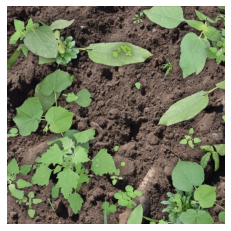

In [49]:
# Define the function to load the input image
def load_input_image(input_path):
    # Use OpenCV to load the input image
    img = cv2.imread(input_path)
    
    input_h, input_w, *_ = img.shape
    print(f"Loaded the input image {input_path}. \nInput image resolution: {input_w}x{input_h}")
    
    return img

# Define the function to resize the input image
def resize_input_image(image):
    # Resize the image dimensions from image to model input w x h
    in_frame = cv2.resize(image, (w, h))
    # Change data layout from HWC to CHW
    in_frame = in_frame.transpose((2, 0, 1))  
    # Reshape to input dimensions
    in_frame = in_frame.reshape((n, c, h, w))
    print(f"Resized the input image to {w} x {h}")
    return in_frame

# Load the image
image = load_input_image(input_image_path)

# Resize the input image
in_frame = resize_input_image(image)

# Display the input image
print("Input image:")
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [50]:
# Save the starting time
inf_start = time.time()

# Run the inference
res = exec_net.infer(inputs={input_blob: in_frame})   

# Calculate time from start until now
inf_time = time.time() - inf_start
print(f"Inference is complete. Run time: {inf_time * 1000:.3f} ms")

Inference is complete. Run time: 147.877 ms


label_colors.txt
Loaded label mapping file [label_colors.txt]
Processed the image and displayed the inference output result.


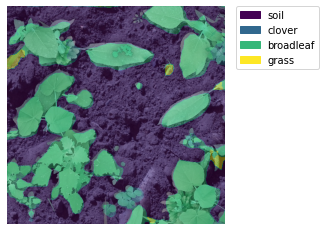

In [51]:
import shutil
from pathlib import Path
import matplotlib.image as mpimg

def load_labels_map():
    labels_map = None
    # If there is a path to a label mapping file, load the file into labels_map
    print(labels_path)
    if os.path.isfile(labels_path):
        labels_map = {}
        with open(labels_path, 'r') as f:
            content = f.read()
        for line in content.split('\n'):
            if line:
                key, value = line.split(sep='=', maxsplit=1)
                labels_map[int(key)] = value
        print(f"Loaded label mapping file [{labels_path}]")
    else:
        print("No label mapping file has been loaded, only numbers will be used",
              "for detected object labels.")
    return labels_map

# Create a function to process inference results
def process_results(result, output):
    # Get output results
    res = result[output_blob]
    
    # Load the names of the classes from the labels_path file if possible
    labels_map = load_labels_map()
    
    res = np.swapaxes(res, 0, 2)
    res = np.swapaxes(res, 0, 1)
    
    resized = cv2.resize(image, res.shape[:2])
    
    class_ids = np.unique(res)
    
    #Disable axis display
    plt.axis("off")
    # Display the original resized image
    plt.imshow(resized)
    # Display the network output as a half-transparent mask
    im = plt.imshow(res, alpha=0.4)
    
    colors = [im.cmap(im.norm(value)) for value in class_ids] #[[166, 86, 40], [228, 26, 28], [155, 126, 184], [255, 127, 0]] 
    patches = [
        mpatches.Patch(
            color=colors[i], 
            label=labels_map[cls] if labels_map else f'Class {cls}',
        ) for i, cls in enumerate(class_ids)
    ]
    # Put the patches as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    cv2.imwrite(output, res)

output = "css_pot_512x512/Images/0001_prediction.jpg"
process_results(res, output)
print("Processed the image and displayed the inference output result.")


prediction/css_pots_512x512/Images/0013.png
Loaded the input image css_pots_512x512/Images/0013.jpg. 
Input image resolution: 512x512
Resized the input image to 512 x 512
label_colors.txt
Loaded label mapping file [label_colors.txt]
prediction/css_pots_512x512/Images/0026.png
Loaded the input image css_pots_512x512/Images/0026.jpg. 
Input image resolution: 512x512
Resized the input image to 512 x 512
label_colors.txt
Loaded label mapping file [label_colors.txt]
prediction/css_pots_512x512/Images/0028.png
Loaded the input image css_pots_512x512/Images/0028.jpg. 
Input image resolution: 512x512
Resized the input image to 512 x 512
label_colors.txt
Loaded label mapping file [label_colors.txt]
prediction/css_pots_512x512/Images/0021.png
Loaded the input image css_pots_512x512/Images/0021.jpg. 
Input image resolution: 512x512
Resized the input image to 512 x 512
label_colors.txt
Loaded label mapping file [label_colors.txt]
prediction/css_pots_512x512/Images/0024.png
Loaded the input image c

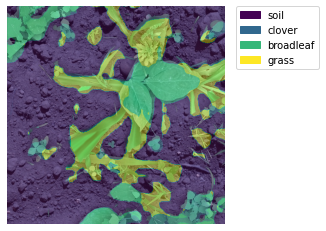

In [52]:
#Process all images in Folder

#img_dir = "css_512x512v2/Images/"
img_dir = "css_pots_512x512/Images/"
# Calculate and save output per image
imgs = Path(img_dir).rglob("*.jpg")
for i in imgs:
    src = str(i)
    output2 = "prediction/" + src[:-3] + "png"
    print(output2)
    # Load the image
    image = load_input_image(src)
    # Resize the input image
    in_frame = resize_input_image(image)
    # Run the inference
    res = exec_net.infer(inputs={input_blob: in_frame})
    process_results(res, output2)
    
    
    

## About this notebook

This notebook was made by Paula Ramos and is part of the CNN Model Training process for the OpenCV Spatial AI Competition.

<p style=background-color:#0071C5;color:white;padding:0.5em;display:table-cell;width:100pc;vertical-align:middle>
<img style=float:right src="https://devcloud.intel.com/edge/static/images/svg/IDZ_logo.svg" alt="Intel DevCloud logo" width="150px"/>
<a style=color:white>Intel® DevCloud for the Edge</a><br>   
<a style=color:white href="#top">Top of Page</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Intel-DevCloud-for-the-Edge-Usage-Agreement.pdf">Usage Agreement (Intel)</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Colfax_Cloud_Service_Terms_v1.3.pdf">Service Terms (Colfax)</a>
</p>